In [1]:
import pandas as pd 
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway

warnings.filterwarnings('ignore')

# 시각화 환경
sns.set(style='whitegrid', palette='pastel')
plt.rcParams['font.family'] = 'Malgun Gothic'   
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def pre_process(df: pd.DataFrame) -> pd.DataFrame:
    '''
    데이터 전처리 함수
    - 결측치 처리, 데이터 타입 변환, 매핑, 파생변수 생성, 기본 지표 계산까지 수행
    Args:
        df (pd.DataFrame): 원본 데이터프레임
    Returns:
        pd.DataFrame: 전처리 완료된 데이터프레임
    '''

    # 1. 결측치 처리
    df['사업장_시도'] = df['사업장_시도'].fillna('미정')
    df['사업장_시군구'] = df['사업장_시군구'].fillna('미정')

    # 2. 기준년월 변환 (YYYYMM → PeriodIndex[월])
    df['기준년월'] = pd.to_datetime(df['기준년월'].astype(str), format='%Y%m', errors='coerce')
    df['기준년월'] = df['기준년월'].dt.to_period('M')  # "2024-12" 형태 유지

    # 3. 대구/경북 여부 플래그
    df['대구경북권_여부'] = df['사업장_시도'].isin(['대구광역시', '경상북도'])

    # 4. 전담고객여부 매핑 (Y/N → True/False)
    df['전담고객여부'] = df['전담고객여부'].map({'N': False, 'Y': True})

    # 5. 좌수 범주 → 숫자 매핑
    seat_map = {
        "0개": 0, "1개": 1, "2개": 2,
        "2개초과 5개이하": 4, "5개초과 10개이하": 8,
        "10개초과 20개이하": 15.5, "20개초과 30개이하": 25.5,
        "30개초과 40개이하": 35.5, "40개초과 50개이하": 45.5,
        "50개 초과": 55
    }
    cols_to_map = [
        "요구불예금좌수","거치식예금좌수","적립식예금좌수",
        "수익증권좌수","신탁좌수","퇴직연금좌수",
        "여신_운전자금대출좌수","여신_시설자금대출좌수","신용카드개수"
    ]
    df[cols_to_map] = df[cols_to_map].replace(seat_map)

    # 6. 거래건수 범주 → 숫자 매핑
    txn_map = {
        "0건": 0, "1건": 1, "2건": 2,
        "2건초과 5건이하": 3, "5건초과 10건이하": 7,
        "10건초과 20건이하": 15, "20건초과 30건이하": 25,
        "30건초과 40건이하": 35, "40건초과 50건이하": 45,
        "50건 초과": 60
    }
    cols_to_map = [
        "외환_수출실적거래건수","외환_수입실적거래건수",
        "창구거래건수","인터넷뱅킹거래건수","스마트뱅킹거래건수",
        "폰뱅킹거래건수","ATM거래건수","자동이체거래건수"
    ]
    df[cols_to_map] = df[cols_to_map].replace(txn_map)

    # 7. 파생 변수 생성
    df['총거래건수'] = df[['창구거래건수','인터넷뱅킹거래건수','스마트뱅킹거래건수',
                         '폰뱅킹거래건수','ATM거래건수','자동이체거래건수']].sum(axis=1)
    df['총잔액'] = df[['요구불예금잔액','거치식예금잔액','적립식예금잔액']].sum(axis=1)
    df['여신잔액'] = df[['여신_운전자금대출잔액','여신_시설자금대출잔액']].sum(axis=1)
    df['외환거래총금액'] = df[['외환_수출실적금액','외환_수입실적금액']].sum(axis=1)
    df['수탁상품총잔액'] = df[['수익증권잔액','신탁잔액','퇴직연금잔액']].sum(axis=1)
    df['카드사용총금액'] = df[['신용카드사용금액','체크카드사용금액']].sum(axis=1)

    # 8. 여신이용률
    df['여신이용률'] = np.where(df['여신한도금액'] == 0, 0, df['여신잔액'] / df['여신한도금액'])

    # 9. 디지털 거래건수 & 비중
    df['디지털거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수',
                            '폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)

    def calc_digital_ratio(row: pd.Series) -> float:
        if row['총거래건수'] == 0:
            return 0.0 if row['디지털거래건수'] == 0 else pd.NA
        return row['디지털거래건수'] / row['총거래건수']

    df['디지털비중'] = df.apply(calc_digital_ratio, axis=1)

    # 10. 창구비중, 요구불회전율
    df['창구비중'] = np.where(df['총거래건수'] == 0, 0, df['창구거래건수'] / df['총거래건수'])
    df['요구불회전율'] = np.where(df['요구불예금잔액'] == 0, 0,
                               (df['요구불입금금액'] + df['요구불출금금액']) / df['요구불예금잔액'])

    # 11. 수치형 컬럼 강제 변환
    cols_numeric = ['여신이용률','디지털비중','창구비중','요구불회전율']
    for col in cols_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 12. 예대마진 계산
    loan_rate = 0.05
    deposit_rate = 0.02
    df["예대마진"] = (df["여신_운전자금대출잔액"] + df["여신_시설자금대출잔액"]) * loan_rate \
                   - df["총잔액"] * deposit_rate

    return df

In [3]:
df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\Project\\Analysis of corporate data\\cor_data.csv", encoding='cp949')
pre_process(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347299 entries, 0 to 347298
Data columns (total 58 columns):
 #   Column       Non-Null Count   Dtype    
---  ------       --------------   -----    
 0   기준년월         347299 non-null  period[M]
 1   업종_대분류       347299 non-null  object   
 2   업종_중분류       347299 non-null  object   
 3   사업장_시도       347299 non-null  object   
 4   사업장_시군구      347299 non-null  object   
 5   법인_고객등급      347299 non-null  object   
 6   전담고객여부       347299 non-null  bool     
 7   요구불예금잔액      347299 non-null  float64  
 8   거치식예금잔액      347299 non-null  float64  
 9   적립식예금잔액      347299 non-null  float64  
 10  수익증권잔액       347299 non-null  float64  
 11  신탁잔액         347299 non-null  float64  
 12  퇴직연금잔액       347299 non-null  float64  
 13  여신한도금액       347299 non-null  float64  
 14  여신_운전자금대출잔액  347299 non-null  float64  
 15  여신_시설자금대출잔액  347299 non-null  float64  
 16  외환_수출실적금액    347299 non-null  float64  
 17  외환_수입실적금액    347299 non-null 

# 3등급으로 분류

### 분류기준

**최우수 고객의 선정 기준**

보통 은행에서 “최우수” 등급은 잔액·거래 규모·관계 기간 등을 종합적으로 반영

예금을 많이 맡기거나(조달 안정성 기여), 장기 거래를 유지하는 고객도 최우수로 분류 가능

따라서 발생하는 문제

데이터에서 보면 최우수 고객인데 예대마진은 낮은 고객이 있을 수 있음

이들은 고객 등급 기준으로 보면 VIP지만, 수익성 기준으로는 낮을 수 있음

예대마진 중심 분석을 하면 이런 고객들이 “이상치처럼” 보이는 현상 발생

따라서 그룹 분류 필요

1- 고마진 고여신

2- 저마진 고예금

3- 기타(위의 두 분류에 속하지 않는 데이터)

**-예대마진: 예대마진**

**-여신 합계(LOAN_SUM): 여신_운전자금대출잔액 + 여신_시설자금대출잔액**

**-예금 합계(DEP_SUM): 요구불예금잔액 + 거치식예금잔액 + 적립식예금잔액**

고마진·고여신

        조건: 예대마진 ≥ p60 그리고 LOAN_SUM ≥ p60

        해석: 이자 마진도 높고, 대출 잔액도 큰 핵심 수익 고객

저마진·고예금

        조건: 예대마진 < p60 그리고 DEP_SUM ≥ p60

        해석: 마진은 낮지만 예금이 커서 조달 기여가 큰 고객

기타

        위 두 조건에 해당하지 않는 최우수 고객

        해석: 현재 규칙 기준에서 핵심/조달형으로 보기 어려운 고객 (추가 점검·세분화 대상)

해당없음: 최우수 등급이 아닌 행(우수, 일반)

### 분류코드

In [4]:
import numpy as np
import pandas as pd

def classify_best_vip_3(
    df: pd.DataFrame,
    *,
    vip_col="법인_고객등급",
    vip_value="최우수",
    margin_col="예대마진",
    loan_cols=("여신_운전자금대출잔액","여신_시설자금대출잔액"),
    deposit_cols=("요구불예금잔액","거치식예금잔액","적립식예금잔액"),
    level_cols=("업종_대분류","사업장_시도"),  # 피어 그룹(업종×지역)
    q=0.60,                      # 컷오프 분위수(0.6=상위40%)
    min_group_size=20,           # 피어 그룹 최소 표본
    label_col="최우수유형"
):
    X = df.copy()

    # 수치형 변환 및 합계 산출
    for c in [margin_col, *loan_cols, *deposit_cols]:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce")
    loan_use = [c for c in loan_cols if c in X.columns]
    dep_use  = [c for c in deposit_cols if c in X.columns]
    X["LOAN_SUM"] = X[loan_use].sum(axis=1, min_count=1) if loan_use else 0.0
    X["DEP_SUM"]  = X[dep_use].sum(axis=1, min_count=1)  if dep_use  else 0.0
    X[[margin_col,"LOAN_SUM","DEP_SUM"]] = X[[margin_col,"LOAN_SUM","DEP_SUM"]].fillna(0.0)

    # 대상: 최우수만 분류
    is_vip = (X[vip_col] == vip_value)
    

    # 피어 분위수 계산(작은 그룹은 전체 최우수 분위수로 대체)
    if level_cols and all(col in X.columns for col in level_cols):
        grp = X.groupby(list(level_cols), dropna=False)
        gsize = grp[margin_col].transform("size")
        g_q_m = grp[margin_col].transform(lambda s: s.quantile(q))
        g_q_l = grp["LOAN_SUM"].transform(lambda s: s.quantile(q))
        g_q_d = grp["DEP_SUM"].transform(lambda s: s.quantile(q))

        vip_view = X.loc[is_vip]
        fb_m = vip_view[margin_col].quantile(q) if not vip_view.empty else X[margin_col].quantile(q)
        fb_l = vip_view["LOAN_SUM"].quantile(q) if not vip_view.empty else X["LOAN_SUM"].quantile(q)
        fb_d = vip_view["DEP_SUM"].quantile(q)  if not vip_view.empty else X["DEP_SUM"].quantile(q)

        q_m = np.where(gsize < min_group_size, fb_m, g_q_m)
        q_l = np.where(gsize < min_group_size, fb_l, g_q_l)
        q_d = np.where(gsize < min_group_size, fb_d, g_q_d)
    else:
        vip_view = X.loc[is_vip]
        q_m = np.full(len(X), vip_view[margin_col].quantile(q) if not vip_view.empty else X[margin_col].quantile(q))
        q_l = np.full(len(X), vip_view["LOAN_SUM"].quantile(q) if not vip_view.empty else X["LOAN_SUM"].quantile(q))
        q_d = np.full(len(X), vip_view["DEP_SUM"].quantile(q)  if not vip_view.empty else X["DEP_SUM"].quantile(q))

    X["_MARGIN_HIGH"] = X[margin_col].values >= q_m
    X["_LOAN_HIGH"]   = X["LOAN_SUM"].values  >= q_l
    X["_DEP_HIGH"]    = X["DEP_SUM"].values   >= q_d

    # 기본 라벨
    X[label_col] = np.where(is_vip, "기타(최우수)", "대상아님(우수,일반)")

    # 1) 고마진·고여신
    mask1 = is_vip & X["_MARGIN_HIGH"] & X["_LOAN_HIGH"]
    X.loc[mask1, label_col] = "고마진·고여신"

    # 2) 저마진·고예금
    mask2 = is_vip & (~X["_MARGIN_HIGH"]) & X["_DEP_HIGH"]
    X.loc[mask2, label_col] = "저마진·고예금"

    # 3) 나머지 최우수는 '기타' 그대로

    return X

In [5]:
df2 = classify_best_vip_3(df, q=0.60, level_cols=("업종_대분류","사업장_시도"))
df2["최우수유형"].value_counts()

최우수유형
대상아님(우수,일반)    205982
고마진·고여신         89222
저마진·고예금         35799
기타(최우수)         16296
Name: count, dtype: int64

In [6]:
vip_df = df2[df2["최우수유형"].isin(["고마진·고여신", "저마진·고예금", "기타(최우수)"])].copy()

극단치는 제거하고 분석

In [7]:
vip_df  = vip_df[vip_df['예대마진'] > -40000]

# 카이제곱검정

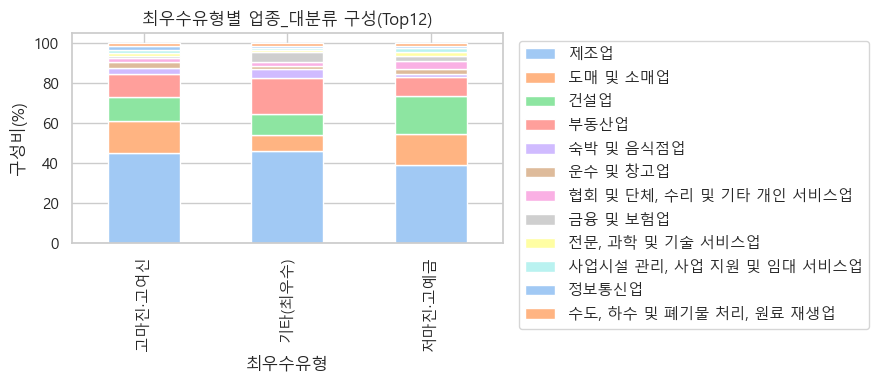

In [8]:
ct = pd.crosstab(vip_df['최우수유형'], vip_df['업종_대분류'])
top = ct.loc[:, ct.sum().sort_values(ascending=False).index[:12]]
(top.div(top.sum(axis=1), axis=0) * 100).plot(kind='bar', stacked=True, figsize=(9,4))
plt.title('최우수유형별 업종_대분류 구성(Top12)')
plt.ylabel('구성비(%)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()

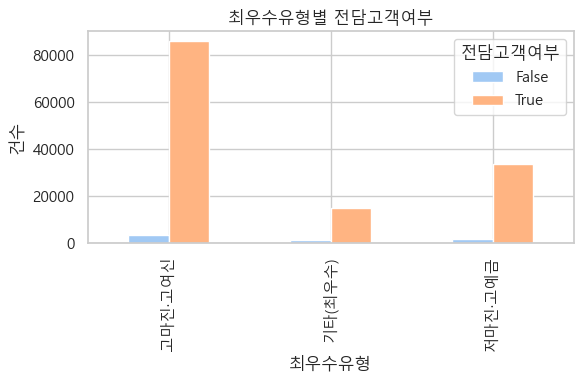

In [9]:
pd.crosstab(vip_df['최우수유형'], vip_df['전담고객여부']).plot(kind='bar', figsize=(6,4))
plt.title('최우수유형별 전담고객여부')
plt.ylabel('건수'); plt.xlabel('최우수유형')
plt.tight_layout(); plt.show()

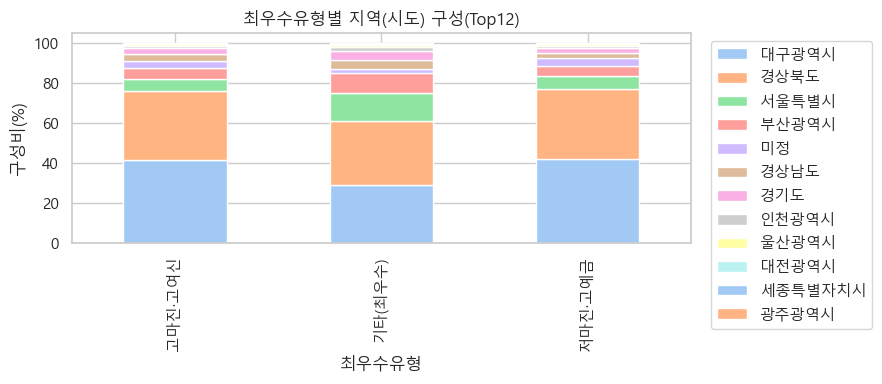

In [10]:
ct = pd.crosstab(vip_df['최우수유형'], vip_df['사업장_시도'])
top = ct.loc[:, ct.sum().sort_values(ascending=False).index[:12]]
(top.div(top.sum(axis=1), axis=0) * 100).plot(kind='bar', stacked=True, figsize=(9,4))
plt.title('최우수유형별 지역(시도) 구성(Top12)')
plt.ylabel('구성비(%)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()

In [11]:
from scipy.stats import chi2_contingency

# 2) 카이제곱 검정 함수 (아주 단순)
def chi_simple(data, by_col):
    tmp = data[['최우수유형', by_col]].dropna()
    ct = pd.crosstab(tmp['최우수유형'], tmp[by_col])   # 교차표(빈도)
    chi2, p, dof, _ = chi2_contingency(ct)           # 카이제곱 검정
    print(f"\n[{by_col}] χ²={chi2:.2f}, df={dof}, p={p:.4g}")
    print(ct)

# 3) 실행: 업종 / 전담 / (예시) 상품보유여부
chi_simple(vip_df, '업종_대분류')
chi_simple(vip_df, '전담고객여부')
chi_simple(vip_df, '사업장_시도')   # 보유여부 컬럼 이름에 맞게 바꿔서 실행


[업종_대분류] χ²=5806.89, df=34, p=0
업종_대분류     건설업   광업  교육 서비스업  금융 및 보험업  농업, 임업 및 어업  도매 및 소매업  \
최우수유형                                                           
고마진·고여신  10115  114      391       882          170     14266   
기타(최우수)   1610    9       42       780            6      1243   
저마진·고예금   6546   62      208       859           14      5382   

업종_대분류   보건업 및 사회복지 서비스업   부동산업  사업시설 관리, 사업 지원 및 임대 서비스업  \
최우수유형                                                       
고마진·고여신              399  10241                      1482   
기타(최우수)              352   2848                       173   
저마진·고예금              512   3196                       615   

업종_대분류   수도, 하수 및 폐기물 처리, 원료 재생업  숙박 및 음식점업  예술, 스포츠 및 여가관련 서비스업  운수 및 창고업  \
최우수유형                                                                        
고마진·고여신                     1292       2625                 1108      2554   
기타(최우수)                      223        653                  181       272   
저마진·고예금                

결과 요약

세 변수 모두 유의: 업종(χ²=5915.8), 전담여부(χ²=420.1), 지역(χ²=3077.1), p≈0 → “최우수유형”은 업종·전담·지역과 무관하지 않음

전담여부: 기타(최우수) 비전담 비율 ↑ (약 7.7%) → 고마진·저마진군보다 비전담 많이 섞임

지역 패턴:

과다: 서울·부산·경기·경남·인천·울산·대전 (+)

과소: 대구·경북 (–)
→ 절대 건수는 대구·경북 많지만, 기대값 대비 수도권·부울경 비중 높음

업종 특성:

기타(최우수): 부동산·금융·숙박·음식 비중 높음

저마진·고예금: 건설·도소매·협회·전문기술 비중 높음

해석

기타군: 수도권·부울경 집중 + 부동산·금융·숙박 업종 많음 → 비전담 비율 높아 가격·조건 관리 느슨할 가능성

저마진군: 대구·경북 및 건설 중심 → 재약정 시 스프레드 추가 하락 위험

# 그룹별 비교

### 여신이용률

         count   mean  median    std  min  max
최우수유형                                         
고마진·고여신  89222  1.697   0.823  2.001  0.0  5.0
기타(최우수)  16296  0.667   0.000  1.381  0.0  5.0
저마진·고예금  35763  0.405   0.000  1.047  0.0  5.0


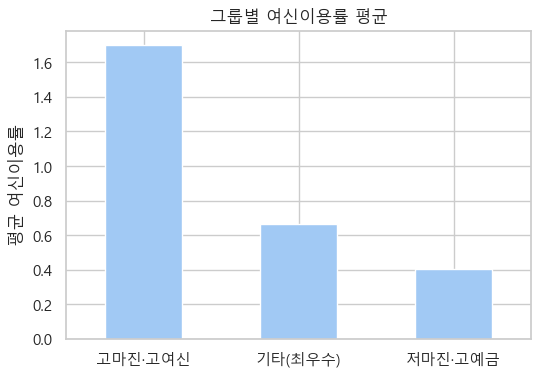

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# vip_df: 최우수 세 그룹만 담긴 DF (이미 준비되어 있다고 가정)
# 안전한 여신이용률 계산 (0나눗셈 방지)
if "여신이용률" not in vip_df.columns:
    denom = vip_df["여신한도금액"].replace(0, np.nan)
    vip_df["여신이용률"] = vip_df["여신잔액"] / denom
vip_df["여신이용률"] = vip_df["여신이용률"].clip(0, 5).fillna(0)  # 이상치/무한값 간단 클리핑

# 1) 그룹별 기초통계
util_stats = vip_df.groupby("최우수유형")["여신이용률"].agg(["count","mean","median","std","min","max"]).round(3)
print(util_stats)


# 3) 평균 막대그래프(해석 용이)
util_means = vip_df.groupby("최우수유형")["여신이용률"].mean().sort_values(ascending=False)
util_means.plot(kind="bar", figsize=(6,4))
plt.title("그룹별 여신이용률 평균")
plt.ylabel("평균 여신이용률")
plt.xlabel("")
plt.xticks(rotation=0)
plt.show()

### 요구불회전율

         count    mean  median     std  min   max
최우수유형                                            
고마진·고여신  89222  19.447   8.667  20.351  0.0  50.0
기타(최우수)  16296  23.863  16.667  21.923  0.0  50.0
저마진·고예금  35763   8.443   2.740  13.640  0.0  50.0


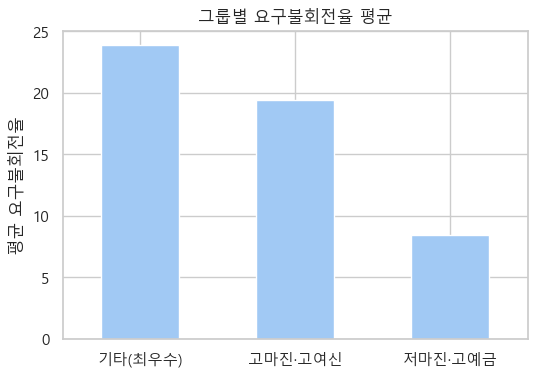

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 안전 계산: 분모가 0이면 NaN 처리
if "요구불회전율" not in vip_df.columns:
    denom = vip_df["요구불예금잔액"].replace(0, np.nan)
    vip_df["요구불회전율"] = (vip_df["요구불입금금액"] + vip_df["요구불출금금액"]) / denom
vip_df["요구불회전율"] = vip_df["요구불회전율"].clip(0, 50).fillna(0)  # 극단치 클리핑

# 1) 그룹별 기초통계
dd_turn_stats = vip_df.groupby("최우수유형")["요구불회전율"].agg(["count","mean","median","std","min","max"]).round(3)
print(dd_turn_stats)

# 3) 평균 막대그래프
dd_turn_means = vip_df.groupby("최우수유형")["요구불회전율"].mean().sort_values(ascending=False)
dd_turn_means.plot(kind="bar", figsize=(6,4))
plt.title("그룹별 요구불회전율 평균")
plt.ylabel("평균 요구불회전율")
plt.xlabel("")
plt.xticks(rotation=0)
plt.show()

### 수탁상품총잔액

        수탁상품총잔액                            상품다양성                   
          count     mean median       std  count  mean median   std
최우수유형                                                              
고마진·고여신   89222   563.68    0.0   5157.15  89222  0.91    0.0  1.01
기타(최우수)   16296   997.76    0.0  16996.45  16296  0.57    0.0  0.88
저마진·고예금   35763  1131.38    0.0  11239.47  35763  0.87    0.0  0.99


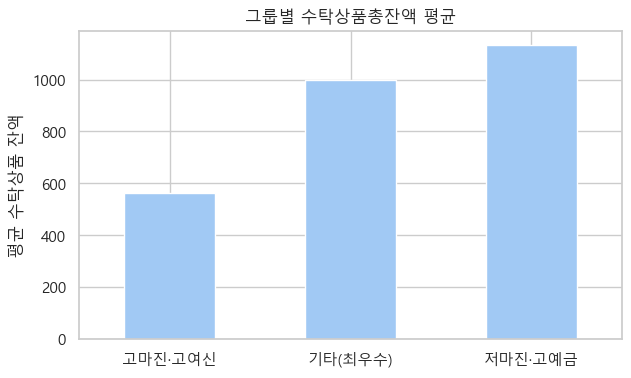

In [14]:
import matplotlib.pyplot as plt

# 1) 상품다양성 계산 (보유 좌수 > 0 인 상품 개수)
product_cols = ["수익증권좌수", "신탁좌수", "퇴직연금좌수"]
vip_df["상품다양성"] = vip_df[product_cols].gt(0).sum(axis=1)

# 2) 그룹별 기초통계 (수탁상품총잔액 + 상품다양성)
product_stats = vip_df.groupby("최우수유형")[["수탁상품총잔액","상품다양성"]].agg(["count","mean","median","std"]).round(2)
print(product_stats)

# 3) 평균 막대그래프 – 수탁상품총잔액
plt.figure(figsize=(7,4))
vip_df.groupby("최우수유형")["수탁상품총잔액"].mean().plot(kind="bar")
plt.title("그룹별 수탁상품총잔액 평균")
plt.ylabel("평균 수탁상품 잔액")
plt.xlabel("")
plt.xticks(rotation=0)
plt.show()

### 창구 비중

          창구비중                      창구거래건수                      
         count   mean median    std  count   mean median     std
최우수유형                                                           
고마진·고여신  89222  0.036    0.0  0.102  89222  2.813    0.0   8.625
기타(최우수)  16296  0.025    0.0  0.097  16296  1.047    0.0   4.478
저마진·고예금  35763  0.057    0.0  0.127  35763  4.694    0.0  11.568


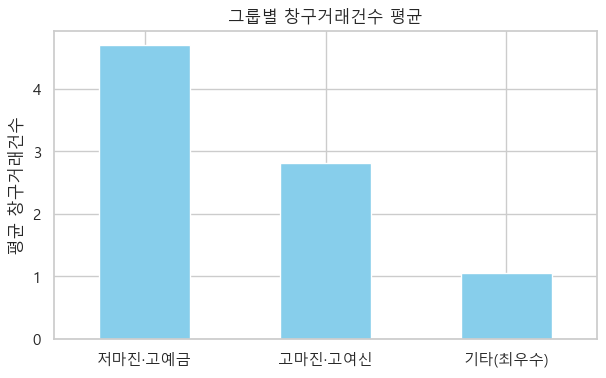

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) 그룹별 기초통계
counter_stats = vip_df.groupby("최우수유형")[["창구비중","창구거래건수"]].agg(["count","mean","median","std"]).round(3)
print(counter_stats)

# 3) 평균 Barplot – 창구거래건수
plt.figure(figsize=(7,4))
vip_df.groupby("최우수유형")["창구거래건수"].mean().sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("그룹별 창구거래건수 평균")
plt.ylabel("평균 창구거래건수")
plt.xlabel("")
plt.xticks(rotation=0)
plt.show()

# 4) 고창구 의존 고객 비율 (창구비중 50% 이상)
vip_df["창구의존구간"] = pd.cut(
    vip_df["창구비중"],
    bins=[-0.01, 0.5, 1.0],
    labels=["저창구(<50%)","고창구(≥50%)"]
)


### 디지털 구간

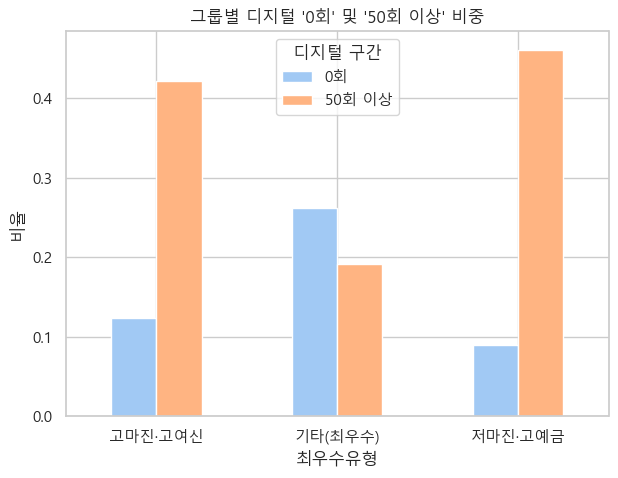


[그룹별 디지털 0회·50회 이상 비율]

디지털구간       0회  50회 이상
최우수유형                 
고마진·고여신  0.123   0.422
기타(최우수)  0.262   0.191
저마진·고예금  0.090   0.461


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 디지털거래건수 합산
digital_cols = ["인터넷뱅킹거래건수","스마트뱅킹거래건수","폰뱅킹거래건수","ATM거래건수"]
vip_df["디지털거래건수합"] = vip_df[digital_cols].sum(axis=1)

# 2) 구간화 (0회 / 1~10회 / 11~50회 / 50회 이상)
vip_df["디지털구간"] = pd.cut(
    vip_df["디지털거래건수합"],
    bins=[-0.1, 0.5, 10, 50, vip_df["디지털거래건수합"].max()],
    labels=["0회", "1~10회", "11~50회", "50회 이상"]
)

# 3) 그룹별 비율 테이블 만들기
dist_digital_bins = pd.crosstab(
    vip_df["최우수유형"],
    vip_df["디지털구간"],
    normalize="index"
).round(3)

# 4) 유의미한 구간만 선택 (0회 + 50회 이상)
dist_digital_focus = dist_digital_bins[["0회", "50회 이상"]]

# 5) 시각화
dist_digital_focus.plot(kind="bar", figsize=(7,5))
plt.title("그룹별 디지털 '0회' 및 '50회 이상' 비중")
plt.ylabel("비율")
plt.xlabel("최우수유형")
plt.xticks(rotation=0)
plt.legend(title="디지털 구간")
plt.show()

# 비율표도 같이 출력해서 확인
print("\n[그룹별 디지털 0회·50회 이상 비율]\n")
print(dist_digital_focus)

### 전담고객여부

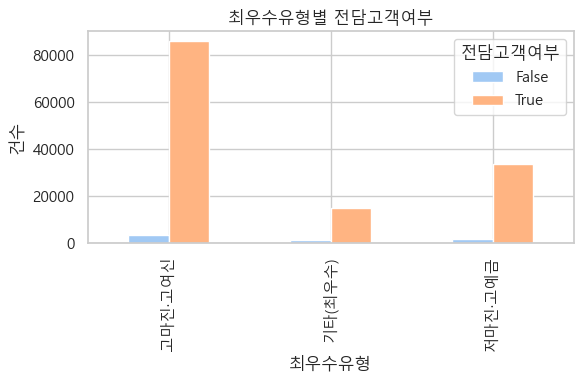

In [17]:
pd.crosstab(vip_df['최우수유형'], vip_df['전담고객여부']).plot(kind='bar', figsize=(6,4))
plt.title('최우수유형별 전담고객여부')
plt.ylabel('건수'); plt.xlabel('최우수유형')
plt.tight_layout(); plt.show()

### 업종별 고객 수

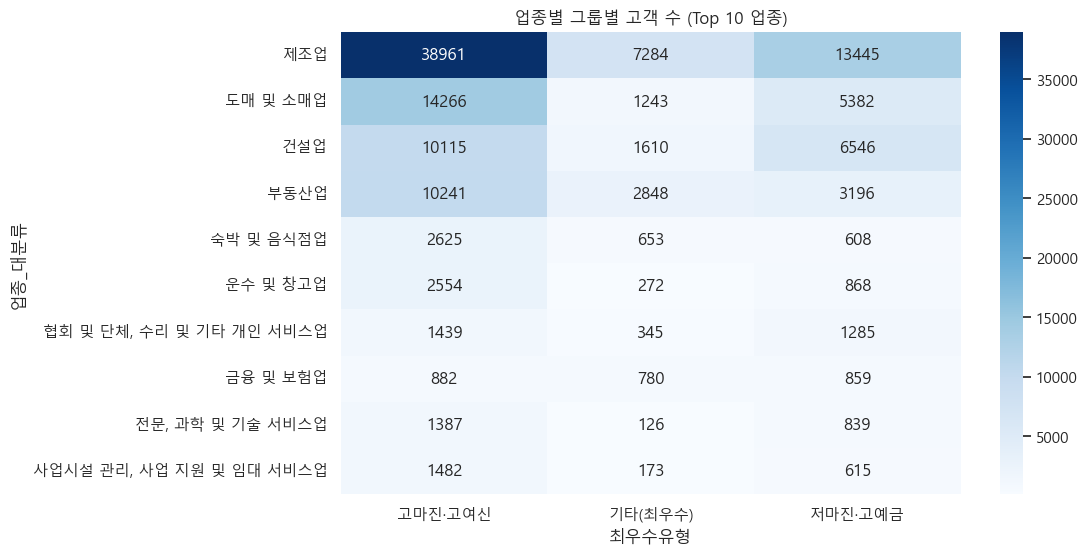


[업종별 그룹별 고객 수 + 총합]

최우수유형                     고마진·고여신  기타(최우수)  저마진·고예금  TOTAL
업종_대분류                                                    
제조업                         38961     7284    13445  59690
도매 및 소매업                    14266     1243     5382  20891
건설업                         10115     1610     6546  18271
부동산업                        10241     2848     3196  16285
숙박 및 음식점업                    2625      653      608   3886
운수 및 창고업                     2554      272      868   3694
협회 및 단체, 수리 및 기타 개인 서비스업     1439      345     1285   3069
금융 및 보험업                      882      780      859   2521
전문, 과학 및 기술 서비스업             1387      126      839   2352
사업시설 관리, 사업 지원 및 임대 서비스업     1482      173      615   2270
정보통신업                        1456      133      399   1988
수도, 하수 및 폐기물 처리, 원료 재생업      1292      223      411   1926
예술, 스포츠 및 여가관련 서비스업          1108      181      340   1629
보건업 및 사회복지 서비스업               399      352      512   1263
교육 서비스업                       391 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 그룹×업종별 고객 수 계산
industry_count = vip_df.pivot_table(
    index="업종_대분류",
    columns="최우수유형",
    values="예대마진",  # count라서 아무 numeric column 써도 됨
    aggfunc="count"
)

# 2) 업종별 총합 구해서 정렬
industry_count["TOTAL"] = industry_count.sum(axis=1)
industry_count = industry_count.sort_values("TOTAL", ascending=False)

# 3) Top N만 보기 (원하면 전체로 볼 수도 있음)
top_n = 10  # 원하는 개수로 조정 가능
industry_top = industry_count.head(top_n).drop(columns="TOTAL")

# 4) 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(industry_top, annot=True, fmt="d", cmap="Blues")  # fmt="d" → 정수 그대로 표시
plt.title(f"업종별 그룹별 고객 수 (Top {top_n} 업종)")
plt.xlabel("최우수유형")
plt.ylabel("업종_대분류")
plt.show()

# 5) 총합 같이 보고 싶으면 industry_count 출력
print("\n[업종별 그룹별 고객 수 + 총합]\n")
print(industry_count)

# 회귀분석

고마진·고여신 그룹 중 어떤 변수가 예대마진을 결정하는데 큰 영향을 미칠까

=> 업종/지역에 따라  예대마진 크기가 어떻게 달라지는지

In [19]:
high_df=vip_df[vip_df['최우수유형']=='고마진·고여신']

In [20]:
import pandas as pd
import statsmodels.formula.api as smf

# 예: df1125 사용
use_cols = ['예대마진','업종_대분류','사업장_시도','전담고객여부']
d = high_df[use_cols].dropna()

# 범주형은 C()로 감싸면 자동으로 원-핫 처리됨
m = smf.ols('예대마진 ~ C(업종_대분류) + C(사업장_시도) + C(전담고객여부)', data=d).fit()
print(m.summary())

# (선택) 이상치 민감도 줄이고 싶으면, 동일 모형에 강건분산(HC1)로 표준오차 보기
print(m.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                   예대마진   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     351.0
Date:                Tue, 16 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:51:31   Log-Likelihood:            -6.6645e+05
No. Observations:               89222   AIC:                         1.333e+06
Df Residuals:                   89191   BIC:                         1.333e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

**모델 요약**

        설명력(R²): 0.107 → 업종/지역/전담여부만으로 마진 변동의 ~11% 설명.

        방향성은 강건표준오차(HC1)로도 변함 없음(유의 계수 동일하게 많음).


**주요 효과(기준군 대비)**
        1.업종

        높음(+): 금융·보험(+606), 예술·스포츠·여가(+468), 숙박·음식(+309), 부동산(+241), 제조(+106), 운수·창고(+64) 등

        낮음(-): 정보통신(-110), 보건·복지(-64), 전문·과학·기술(-35) 등

        2.지역

        높음(+): 광주(+887), 대전(+203), 서울(+178)

        낮음(-): 경북(-142), 세종(-153), 대구(-102), 울산(-94), 경남(-74), 부산(-65), 인천(-55)
        (광주/세종은 표본이 적을 수 있어 해석 주의)

        3.전담여부

        전담 고객(True): +59 → 전담이 평균적으로 마진 높임.


**해석 한 줄**

        업종/지역/전담여부 차이가 마진에 분명한 영향. 특히 금융·부동산·숙박/여가·제조가 높고, 경북/대구 등 일부 지역은 낮음. 전담 효과는 +.